In [1]:
!pip install catboost


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install lightgbm


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Описание проекта


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание данных



Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План проекта

1. Первым делом необходимо изучить данные, проверить на наличие пропусков, неправильные типы данных и т.д.

2. Далее подготовить данные. Изучить выбросы и аномалии, при необходимости, отчистить данные от них.

3. Визуализировать полученные результаты и сделать выводы.

4. Обучить несколько моделей с подобранными параметрами и выбрать среди них наилучшую.

5. Протестировать модель с лучшим показателем метрики и сделать выводы по итогам работы.

6. Провести анализ лучшей модели (важность признаков и матрица ошибок)

## Цель проекта

Необходимо разработать модель, которая позволит прогнозировать отток клиентов для того, чтобы компания могла вовремя попытаться удержать клиента.


---

# Импорты

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings

from IPython.display import display
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

size = (14,6)
RANDOM_STATE = 100423
warnings.filterwarnings("ignore")

---

# Функции

In [4]:
def analysis(data):
  display(data.head())
  print()
  data.info()
  print()
  display(data.describe())

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

---

# Исследовательский анализ данных

In [5]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv',  index_col=['customerID'])
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv',  index_col=['customerID'])
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv',  index_col=['customerID'])
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv',  index_col=['customerID'])

## Первичное изучение данных

In [6]:
analysis(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB



,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


**Вывод по** `contract_new.csv`

- Структура данных состоит из 8 колонок и 7043 строк
- Пропусков в данных не наблюдается
- Необходимо изменить тип данных в следующих колонках: `BeginDate`, `EndDate`, `MonthlyCharges`, `TotalCharges`

In [7]:
analysis(personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB



,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


**Вывод по** `personal_new.csv`

- Структура данных состоит из 4 колонок и 7043 строк
- Пропусков в данных не наблюдается

In [8]:
analysis(internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB



,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


**Вывод по** `internet_new.csv`

- Структура данных состоит из 7 колонок и 5517 строк
- Данный датасет имеет меньшее кол-во строк, что говорит о том, что данные есть не по всем клиентам (оно и логично, так как не все клиенты пользуются всеми услугами)

In [9]:
analysis(phone)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes



<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB



,MultipleLines
count,6361
unique,2
top,No
freq,3390


**Вывод по** `phone_new.csv`

- Структура данных состоит из 1 колонки и 6361 строки
- Данный датасет, как и `internet_new.csv` имеет меньшее кол-во строк, что говорит о том, что данные есть не по всем клиентам

## Подготовка данных

In [10]:
# добавляем новый стобец Churn, который будет нашим целевым признаком

contract['Churn'] = (contract['EndDate'] != 'No').astype(int)

In [11]:
# меняем тип данных

contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [12]:
# заменяем все значения No в столбце EndDate на актуальную дату. (1 февраля 2020)

contract['EndDate'] = contract['EndDate'].where(contract['EndDate'] != 'No', '2020-02-01')
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [13]:
# при попытке преобразовать колонку произошла ошибка, в столбце есть пропуски

contract['TotalCharges'].value_counts().head()

         11
20.45     6
101.0     5
21.53     4
40.1      4
Name: TotalCharges, dtype: int64

In [14]:
# заполним все 11 пропусков нулями и изменим тип данных

contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [15]:
# выводим информацию, чтобы проверить изменились ли все типы данных

contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(3)
memory usage: 467.7+ KB


In [16]:
#создадим копию датасета, чтобы объединить все файлы в 1 датасет

data = contract.copy()
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0


In [17]:
# присоединяем все датасеты в 1

data = data.join(personal)
data = data.join(internet)
data = data.join(phone)

In [18]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   int32         
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

In [20]:
# заполняем пропуски

data = data.fillna('No')

In [21]:
#добавим новую колонку. п.с. В дальнейшем, при обучении модели именно она окажется наиболее влиятельным признаком

data['TotalDays'] = (data['EndDate'] - data['BeginDate']).dt.days

In [22]:
# проверяем на наличие пропусков

data.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
TotalDays           0
dtype: int64

## Визуализация данных

In [23]:
data['Churn'].value_counts()

0    5942
1    1101
Name: Churn, dtype: int64

Text(0.5, 1.0, 'Баланс классов')

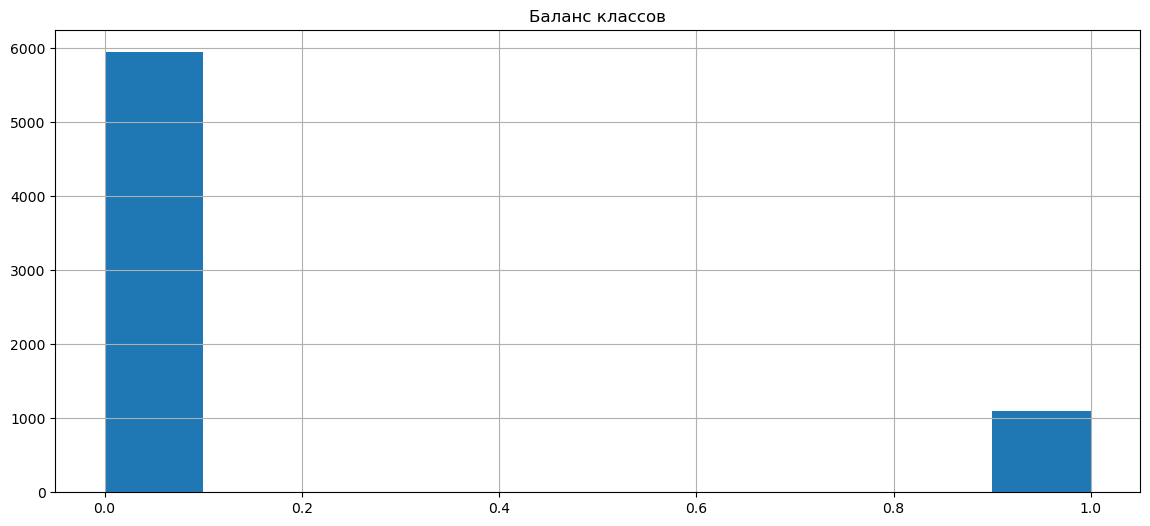

In [24]:
data['Churn'].hist(figsize=size)
plt.title('Баланс классов')

Можно заметить сильный дисбаланс классов. Но метрика ROC-AUC не чувствительная к дисбалансу классов. Поэтому на это можно не обращать внимания.

In [25]:
columns = ['Type', 'PaperlessBilling', 'PaymentMethod',
           'MonthlyCharges', 'TotalCharges', 'Churn', 'gender', 'SeniorCitizen',
           'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies', 'MultipleLines', 'TotalDays']

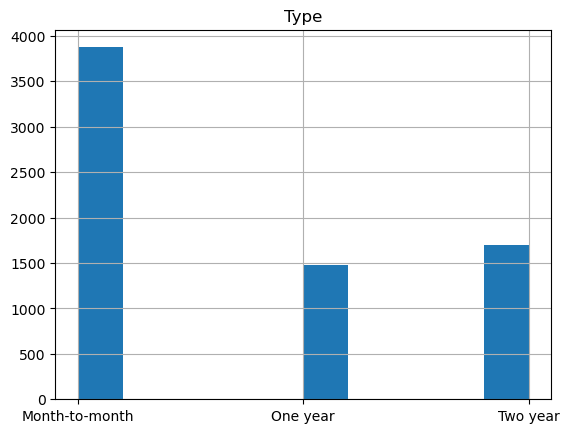

<Figure size 2000x3500 with 0 Axes>

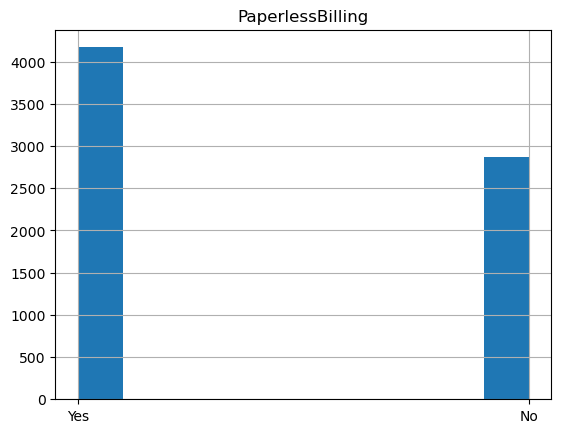

<Figure size 2000x3500 with 0 Axes>

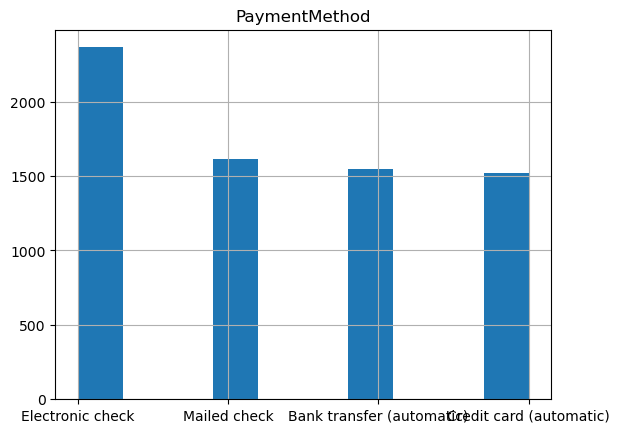

<Figure size 2000x3500 with 0 Axes>

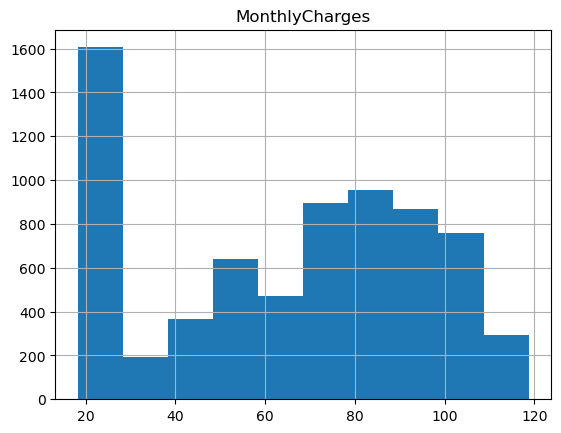

<Figure size 2000x3500 with 0 Axes>

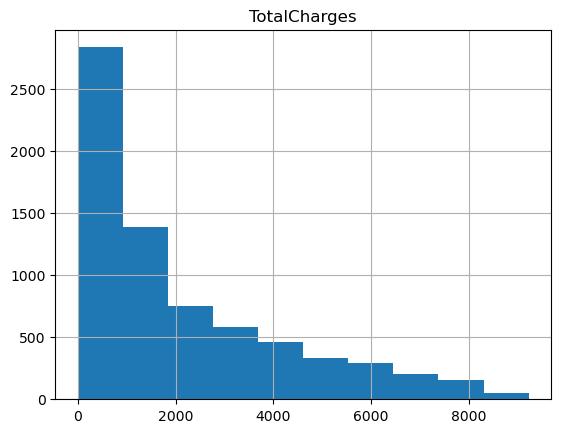

<Figure size 2000x3500 with 0 Axes>

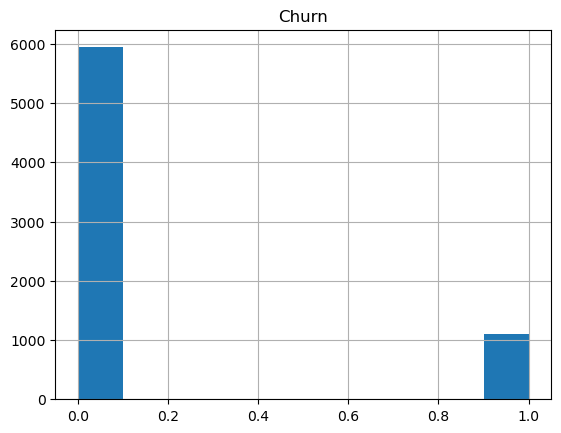

<Figure size 2000x3500 with 0 Axes>

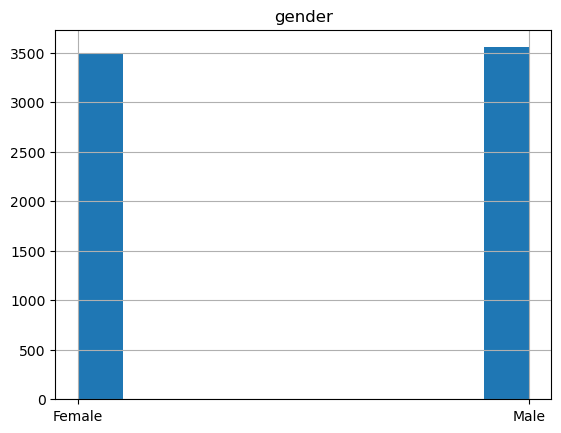

<Figure size 2000x3500 with 0 Axes>

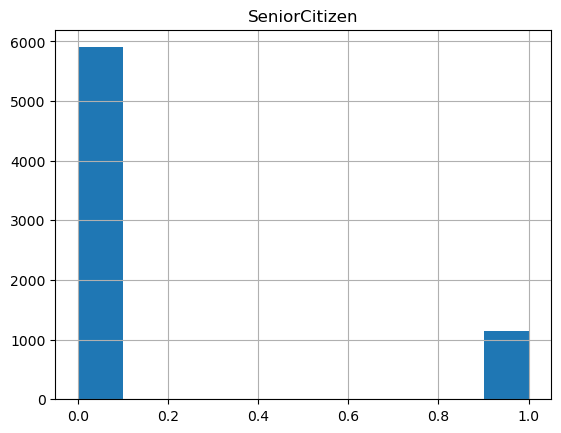

<Figure size 2000x3500 with 0 Axes>

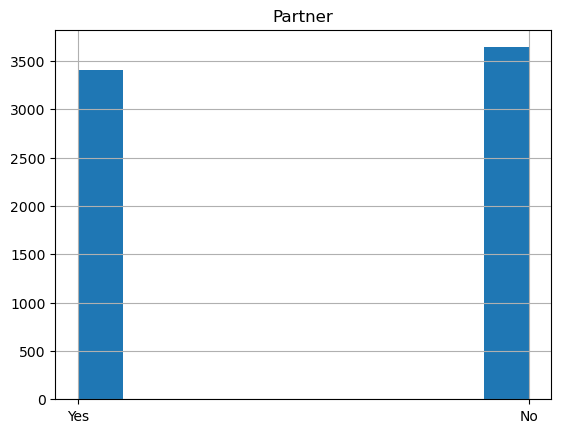

<Figure size 2000x3500 with 0 Axes>

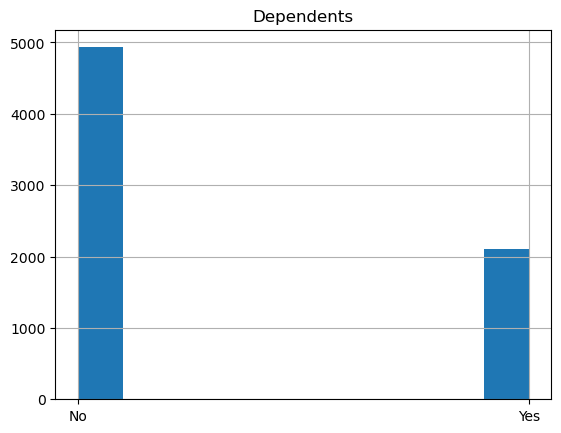

<Figure size 2000x3500 with 0 Axes>

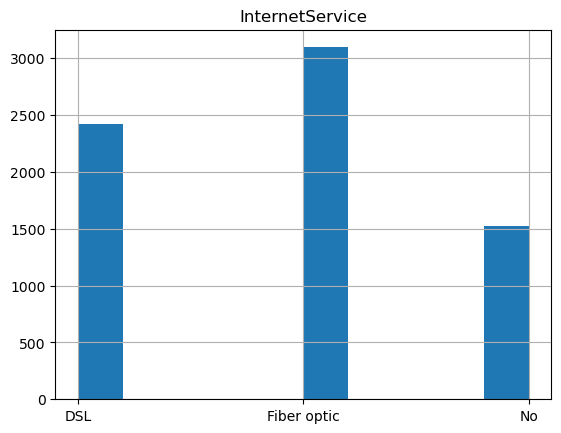

<Figure size 2000x3500 with 0 Axes>

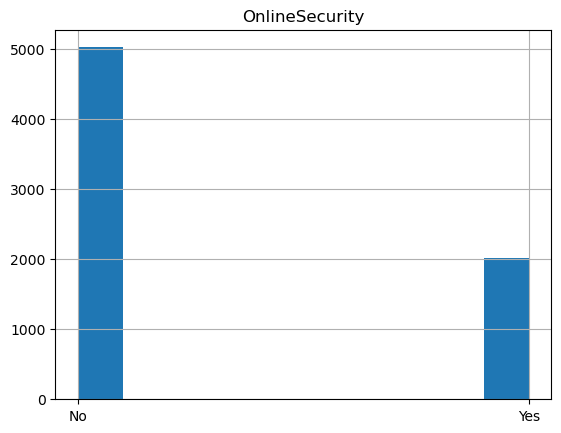

<Figure size 2000x3500 with 0 Axes>

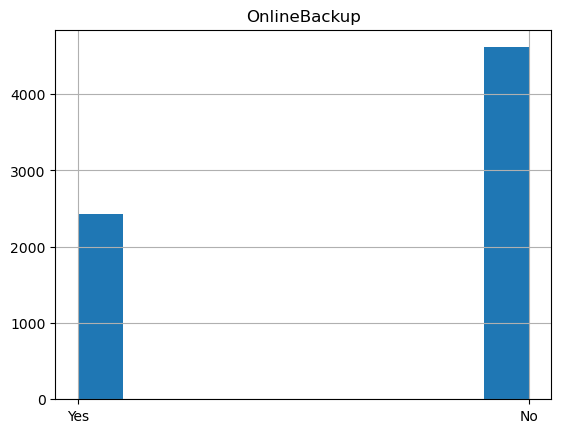

<Figure size 2000x3500 with 0 Axes>

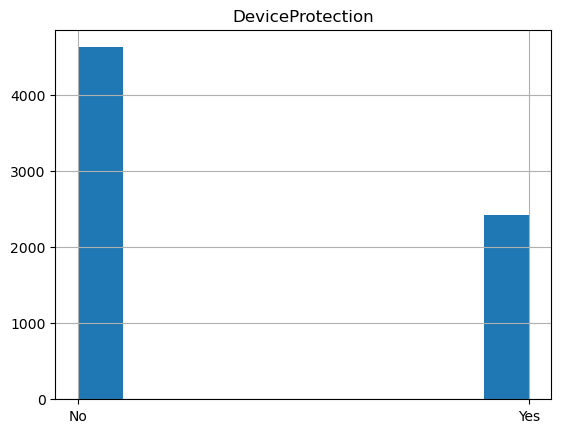

<Figure size 2000x3500 with 0 Axes>

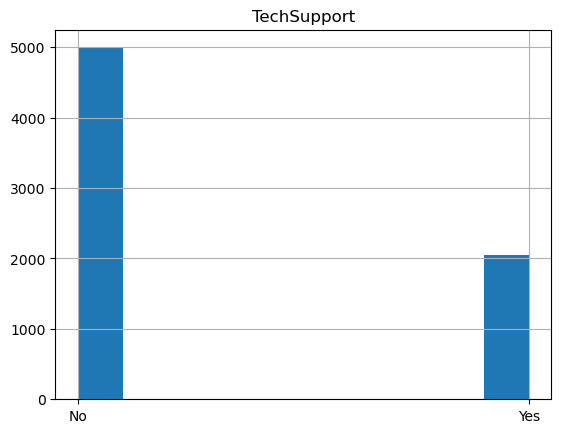

<Figure size 2000x3500 with 0 Axes>

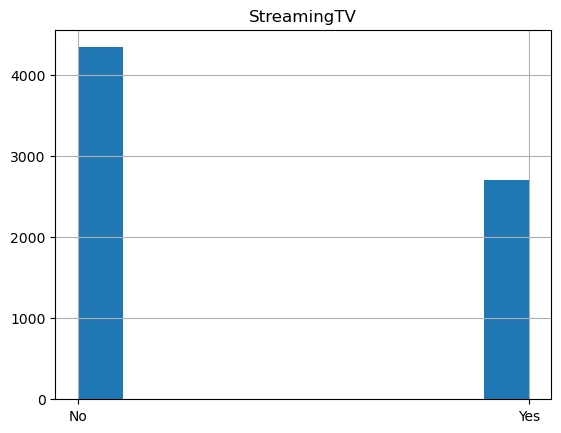

<Figure size 2000x3500 with 0 Axes>

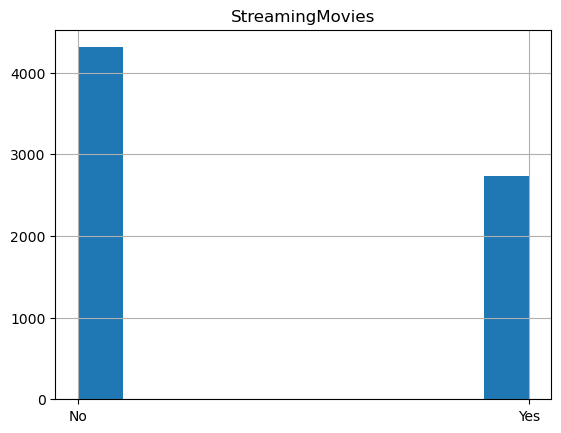

<Figure size 2000x3500 with 0 Axes>

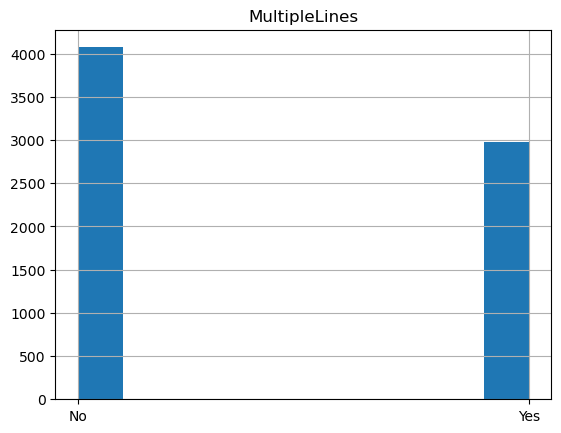

<Figure size 2000x3500 with 0 Axes>

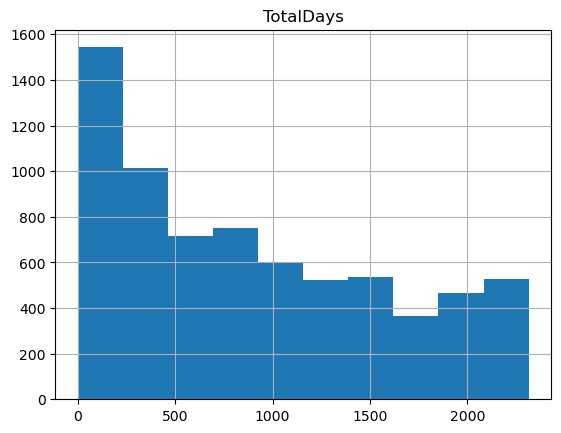

<Figure size 2000x3500 with 0 Axes>

In [26]:
for i in columns:
  data[i].hist()
  plt.title(i)
  plt.figure(figsize=(20,35))
  plt.show()

**Вывод:**

Можно заметить, что наиболее популярны ежемесячные платежи. Большинство клиентов получает чеки в электронном виде и оплачивает их с помощью электронных платежей. Большинство клиентов использует оптоволокно в качестве подключения к сети Интернет. Все доп. услуги не являются популярными и лишь меньшинство клиентов ими пользуется.

In [27]:
charges = data.query('MonthlyCharges < 40')

In [28]:
charges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1837 entries, 7590-VHVEG to 4801-JZAZL
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         1837 non-null   datetime64[ns]
 1   EndDate           1837 non-null   datetime64[ns]
 2   Type              1837 non-null   object        
 3   PaperlessBilling  1837 non-null   object        
 4   PaymentMethod     1837 non-null   object        
 5   MonthlyCharges    1837 non-null   float64       
 6   TotalCharges      1837 non-null   float64       
 7   Churn             1837 non-null   int32         
 8   gender            1837 non-null   object        
 9   SeniorCitizen     1837 non-null   int64         
 10  Partner           1837 non-null   object        
 11  Dependents        1837 non-null   object        
 12  InternetService   1837 non-null   object        
 13  OnlineSecurity    1837 non-null   object        
 14  OnlineBackup  

<AxesSubplot:>

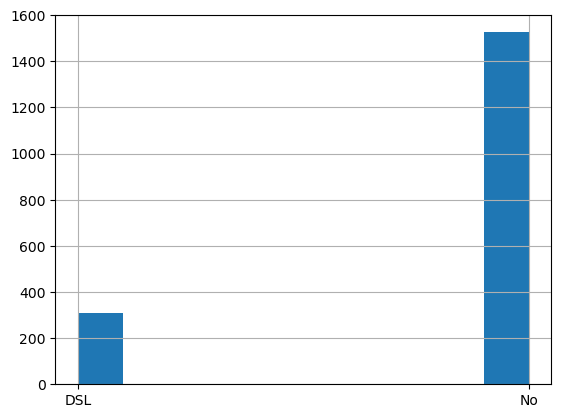

In [29]:
charges['InternetService'].hist()

Было замечено, что большинство платежей менее 30 у.е. (условных единиц).
Связано это с тем, что большинство клиентов не пользуется интернетом.

## Чистка выбросов в количественных данных

In [30]:
num_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']

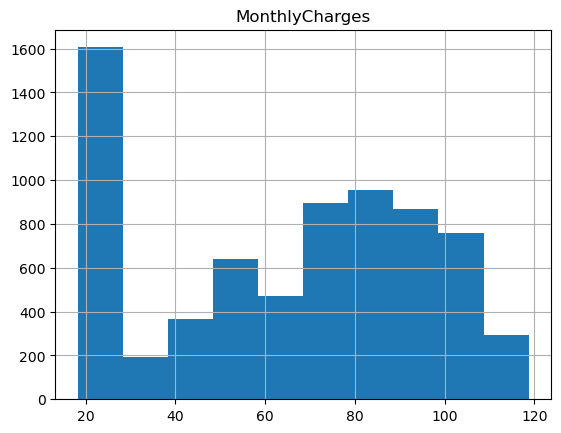

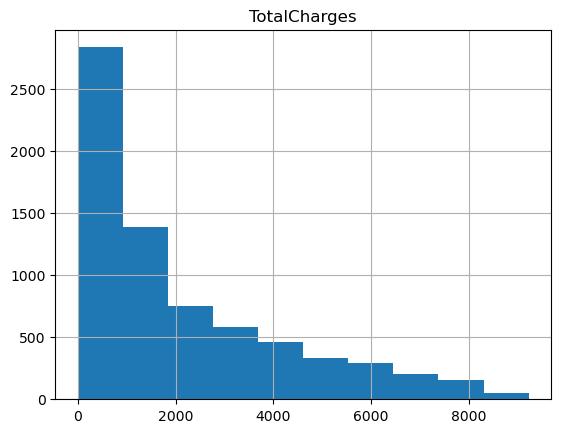

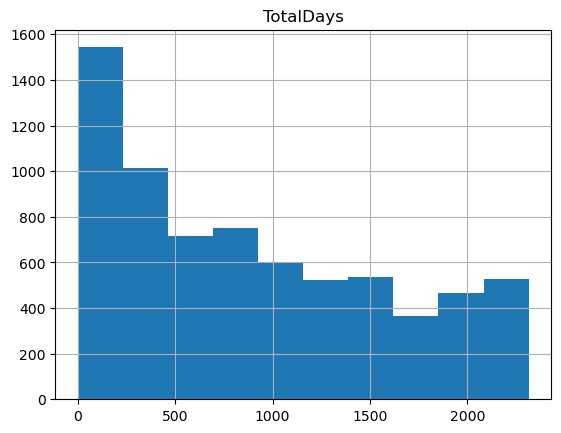

In [31]:
for i in num_columns:
  data[i].hist()
  plt.title(i)
  plt.show()

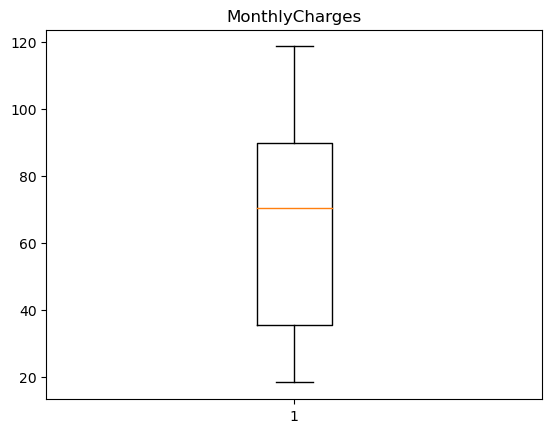

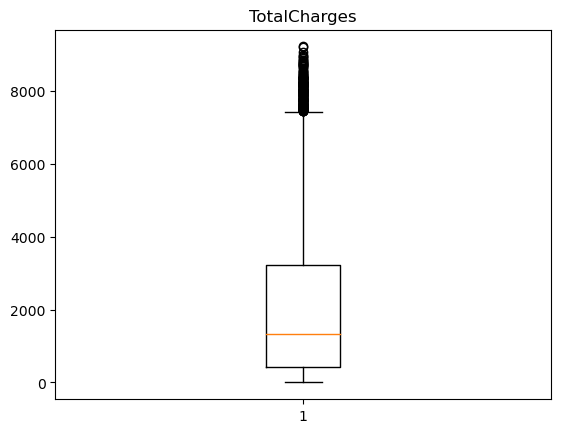

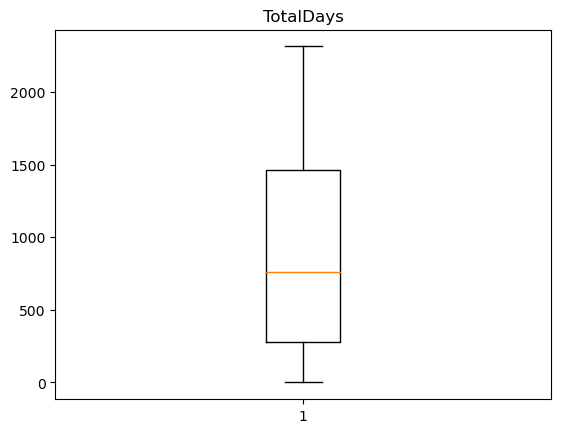

In [32]:
for i in num_columns:
  plt.boxplot(data[i])
  plt.title(i)
  plt.show()

В столбце `TotalCharges` замечены выбросы НО их значения максимально приближены к верхнему усу. На графике нет аномальных значений, эти выбросы лишь говорят о существовании клиентов которые долго пользуются данным оператором. Они оказались за пределами диаграммы размаха скорее всего из-за большого кол-ва новых пользователей или постоянных пользователей но сумма их платежей очень мала. В данном случае чистка не нужна, более того, если же ее применить, то мы потеряем более 3 тыс. данных, что невозможно при общем кол-во данных в 7 тыс.

# Подготовка к обучению моделей

In [33]:
# удалим ненужные столбцы

del data['BeginDate'], data['EndDate']

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Churn             7043 non-null   int32  
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null 

In [35]:
# выделяем таргеты и фичи, делим на выборки 

target = data['Churn']
features = data.drop(columns=['Churn'])

features_train, features_test, target_train, target_test = train_test_split(features, target,test_size=0.2, random_state=RANDOM_STATE)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)  

(5634, 18)
(1409, 18)
(5634,)
(1409,)


In [36]:
#'SeniorCitizen' — категориальный бинарный признак

numeric_columns = features_train.select_dtypes(exclude='object').columns.to_list()
numeric_columns.remove('SeniorCitizen')
numeric_columns

['MonthlyCharges', 'TotalCharges', 'TotalDays']

In [37]:
#категориальные признаки

categorial_columns = features_train.select_dtypes(include='object').columns.to_list()
categorial_columns

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [38]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [39]:
# удаляем первый признак из закодированных, обходя тем самым dummy-ловушку

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train_ohe[categorial_columns])
features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[categorial_columns])

features_train_ohe = features_train_ohe.drop(categorial_columns, axis=1)

# создаём скелер

scaler = StandardScaler()
features_train_ohe[numeric_columns] = scaler.fit_transform(features_train_ohe[numeric_columns])

features_train_ohe.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,TotalDays,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
3392-EHMNK,0.974597,1.989671,0,1.676391,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
1240-HCBOH,-1.288535,-0.175523,0,1.676391,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1442-OKRJE,1.275793,2.552350,0,1.630862,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
8595-SIZNC,-1.305176,-0.738919,1,-0.335679,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4039-PIMHX,-0.499767,0.211090,1,0.870094,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[categorial_columns])

features_test_ohe = features_test_ohe.drop(categorial_columns, axis=1)

features_test_ohe[numeric_columns] = scaler.transform(
    features_test_ohe[numeric_columns]
)

features_test_ohe.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,TotalDays,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
8042-RNLKO,-1.310168,-0.208314,0,1.630862,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4282-YMKNA,0.330602,-0.615809,0,-0.826213,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1113-IUJYX,1.368981,-0.073056,0,-0.514856,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3030-ZKIWL,-1.489888,-0.996761,0,-1.275625,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2451-YMUXS,-0.008867,0.557939,1,0.959682,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [41]:
print(features_test_ohe.shape)
print(features_train_ohe.shape)

(1409, 22)
(5634, 22)


# Обучение моделей

## RandomForest

In [42]:
%%time

rf = RandomForestClassifier(random_state=RANDOM_STATE)

rf_param = {'max_depth': [x for x in range(8, 12, 2)],
            'n_estimators': [x for x in range(10, 15, 1)]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=RANDOM_STATE)

rf_grid = GridSearchCV(rf, rf_param, cv=cv, scoring='roc_auc', n_jobs=-1)

rf_grid.fit(features_train_ohe, target_train)

rf_grid.best_score_

Wall time: 19.9 s


0.8130141376982145

## LightGBM

In [43]:
%%time

lgbm = LGBMClassifier(random_state=RANDOM_STATE)

lgbm_param = {'learning_rate': [0.001, 0.1, 0.3],
             'max_depth': [x for x in range(4, 16, 2)]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=RANDOM_STATE)

lgbm_grid = GridSearchCV(lgbm, lgbm_param, scoring='roc_auc', cv=cv, n_jobs=-1)

lgbm_grid.fit(features_train_ohe, target_train)

lgbm_grid.best_score_

Wall time: 51 s


0.8899934867477529

## Catboost

In [44]:
%%time

cat = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, n_estimators=100)

cat_param = {'n_estimators':[x for x in range(10, 15, 1)],
             'depth':[x for x in range(8, 12, 2)],
             'learning_rate':[0.001, 0.1, 0.3]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=RANDOM_STATE)

cat_grid = GridSearchCV(cat, cat_param, cv=cv, scoring='roc_auc', n_jobs=-1)

cat_grid.fit(features_train_ohe, target_train)

cat_grid.best_score_

Wall time: 3min 45s


0.822469418687365

**Вывод**

Наилучшая модель - LightGBM. Ее показатель метрики ROC-AUC оказался самым высоким среди всех обученных моделей.

# Тестирование лучшей модели

In [45]:
%%time 

lgbm_pred_proba_test = lgbm_grid.predict_proba(features_test_ohe)[:, 1]

print('ROC-AUC: ', roc_auc_score(target_test, lgbm_pred_proba_test))

ROC-AUC:  0.9023730092537433
Wall time: 28 ms


# Борьба с дисбалансом классов

Мы не боремся с дисбалансом классов в данном случае, особенно при помощи апсемплинга, так как он приводит к утечке в сочетании с кросс-валидацией. Метрика `ROC-AUC` не чувствительна к дисбалансу, поэтому заниматься данным преобразованием нет никакого смысла.

# Матрица ошибок и важность признаков



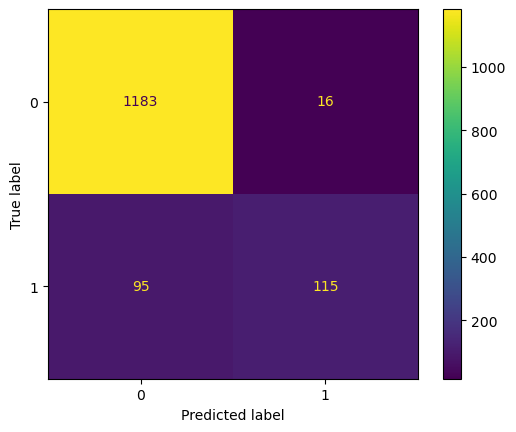

In [46]:
lgbm_pred = lgbm_grid.predict(features_test_ohe)
cm = confusion_matrix(target_test, lgbm_pred, labels=lgbm_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=lgbm_grid.classes_)
disp.plot()
plt.show()

Из матрицы ошибок можно сделать вывод, что с ошибкой 2 рода столкнулись 95 клиентов из тестовой выборки. Также еще 16 столкнулись с ошибкой 1 рода. Модель смогла правильно спрогнозировать целевой признак у остальных клиентов из тестовой выборки.

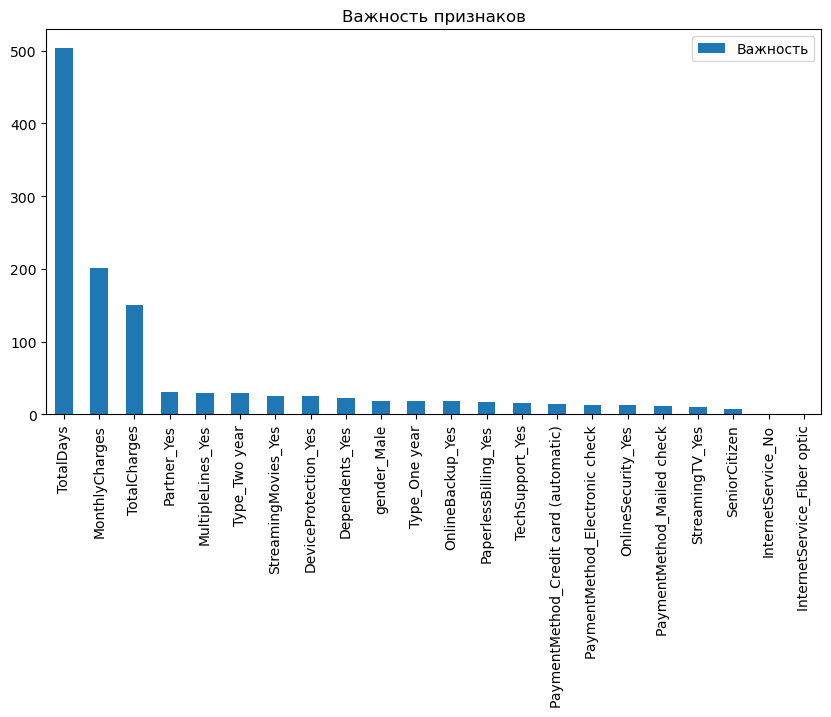

In [47]:
importance = pd.DataFrame(lgbm_grid.best_estimator_.feature_importances_, index = features_test_ohe.columns, columns=['Важность'])
importance = importance.sort_values(by='Важность', ascending=False)

importance.plot(kind='bar', figsize=(10, 5), title='Важность признаков')
plt.show()

На графике видно, что созданная нами дополнительная колонка `TotalDays` оказалась самой важной. Ежемесячные платежи и общая сумма платежей тоже оказывают сильное влияние на модель. Остальные признаки имеют малую важность.

# Вывод

В ходе проделанной работы были выполнены следующие шаги.
- Был составлен план проекта и его цели.
- Загружены данные и изучены
- Перевод форматов данных в нужный
- Проверка на выбросы и аномалии, а так же их визуализация в виде гистограмм и диаграмм размаха

Затем, на подготовленных данных было обучено 3 модели. Random Forest, LightGBM, Catboost. В ходе обучения моделей, наилучшей оказалась LightGBM. На обучающей выборке ее метрика показала значение в 0.88, в то время, как у других моделей метрика не перешла порог в 0.83.
На тесте, модель показала себя еще лучше, и ее метрика ROC-AUC увеличилась до 0.90.

Среди всех факторов, наиболее важными оказались следующие:
1. Общее кол-во дней обслуживания
2. Размер ежемесячных платежей
3. Сумма всех платежей

Касательно данных, были получены следущие результаты:
 - Чаще всего клиенты пользуются сотовой связью
 - Большинство клиентов - "новые", их сумма всех платежей не велика, как и общее кол-во дней обслуживания.
 - Дополнительные услуги пользуются малым спросом, поэтому клиенты чаще не пользуются ими.

1. План состоял из 6 пунктов, в которые входило: изучение данных, проверка на пропуски и аномалии, заполнение данных и их подготовка к анализу, визуализация данных, обучение модели, тестирование лучшей и ее анализ. В ходе работы над проектом все пункты были выполнены.
2. Ключевыми шагами были: добавление дополнительной колонки `TotalDays`, которая повлияла на итоговую метрику в лучшую сторону и стала самым важным фактором (см график важности признаков)
3. Наилучшей моделью стала LightGBM на кросс-валидации с перебором 2 параметров `learning_rate` и `max_depth`. Модель обучалась примерно 2 минуты на обучающих данных и ее метрика составила 0.88, что выше на 0.03 ожидаемого результата. На тесте метрика стала лучше и ее значение составило 0.90
4. Согласно графику важности признаков можно сделать вывод, что наиболее важными оказались: `TotalDays`, `MonthlyCharges`, `TotalCharges`.
    - `TotalDays` искусственно созданная колонка, которая оказала большое влияние на результат метрики, считалась как разница между конечным днем отчетности и первым днем клиента в компании
    - `MonthlyCharges` и `TotalCharges` - с данными колонками были проведены работы по выявлению пропусков и аномалий. На графиках были замечены аномальные значения, но эти выбросы лишь говорят о существовании клиентов которые долго пользуются данным оператором.
